# Baseline Model
In this notebook, we are aiming to create a minimalist model, possessing efficiency, simplicity and explainability. The model is aimed to be light in terms of computational resources and easy to deploy.

The main file of the dataset has 122 columns. For our model to be light and simple, we need to reduce the number of features used. The following methods were used to reduce the number of features:
1. dropping columns with many null values;
2. dropping columns with low variance;
3. checking for multicollinearity.

Dealing with outliers:
1. Interquartile range method (dropping)

The following algorithms were tested:
1. Logistic Regression
2. Decision Tree

Feature Selection:
* RFECV (Recursive feature elimination with cross-validation)

Dealing with class imbalance:
* Random Undersampling
* Random Oversampling
* SMOTE (Synthetic Minority Over-sampling Technique)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys
dir_path = "/content/drive/MyDrive/Colab Notebooks/LoanDefaults/"
sys.path.append(dir_path + "utils/")

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    FunctionTransformer,
    StandardScaler,
    OneHotEncoder,
    normalize,
    OrdinalEncoder,
    PolynomialFeatures)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import mutual_info_regression, RFECV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
)

from matplotlib.lines import Line2D

from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import joblib
import os

import plot_functions as my
import helper as hl

In [ ]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

For the minimalistic model, we will try to use as little features as possible to reach adequate performance.

We will use ROC AUC score as the target metric to indicate model predictive power. Later we will tune the model's threshold according to our needs. Since we have an imbalanced dataset, we will set the bar quite low:
* AUC: 0.7

In [ ]:
X_train = pd.read_pickle(dir_path + "data/train.pkl")
X_valid = pd.read_pickle(dir_path + "data/valid.pkl")
X_test = pd.read_pickle(dir_path + "data/test.pkl")

loans = X_train.copy()

y_train = X_train.pop("TARGET")
y_valid = X_valid.pop("TARGET")
y_test = X_test.pop("TARGET")

print(X_train.shape, X_valid.shape, X_test.shape)
print(loans.shape)
loans.head(3)

(276759, 123) (15376, 123) (15376, 123)
(276759, 124)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMERGENCYSTATE_MODE_MISSING,DAYS_EMPLOYED_ANOMALY
234502,371646,False,Cash loans,F,False,True,0,180000.000,781920.000,28215.000,675000.000,Unaccompanied,Commercial associate,Higher education,Civil marriage,House / apartment,0.036,-13752,-4125.000,-638.000,-4548,NaN,True,True,False,True,True,False,Accountants,2.000,2,2,WEDNESDAY,11,False,True,True,False,True,True,Business Entity Type 3,NaN,0.504,0.356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.000,0.000,0.000,0.000,-105.000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,0.000,1.000,True,False
34261,139700,False,Cash loans,F,True,True,1,202500.000,1006920.000,42790.500,900000.000,"Spouse, partner",Working,Higher education,Married,House / apartment,0.011,-10881,-3714.000,-142.000,-274,4.000,True,True,False,True,True,False,High skill tech staff,3.000,2,2,SATURDAY,10,False,False,False,True,False,True,Business Entity Type 3,NaN,0.324,NaN,0.088,0.048,0.982,0.755,0.031,0.080,0.035,0.458,0.042,0.046,0.071,0.076,0.000,0.000,0.089,0.050,0.982,0.765,0.032,0.081,0.035,0.458,0.042,0.048,0.078,0.080,0.000,0.000,0.088,0.048,0.982,0.758,0.031,0.080,0.035,0.458,0.042,0.047,0.073,0.078,0.000,0.000,org spec account,block of flats,0.077,"Stone, brick",False,0.000,0.000,0.000,0.000,-2257.000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000,0.000,0.000,0.000,0.000,0.000,False,False
265488,407492,False,Cash loans,F,False,False,0,36000.000,814041.000,23931.000,679500.000,Children,Pensioner,Secondary / secondary special,Single / 

# 1. Data Preparation

## 1.2. Null Values
In the file, we have 122 features. For a minimalistic/baseline model this is quite a lot, so we will try to reduce the number of features by generalizing.

First of all, we will be dropping columns related to loan applicant apartment / living area, since it's not applicable to more than 60% of loan applicants, resulting in null values.

In [ ]:
building_cols = [
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "TOTALAREA_MODE",
    "WALLSMATERIAL_MODE",
    "EMERGENCYSTATE_MODE",
                  ]

In [ ]:
loans.drop(columns=building_cols, inplace=True)

Next, we will drop columns with high number of null values. To make it simple, we will make 50% as the threshold.

In [ ]:
perc_threshold = 50

nulls_info = hl.get_null_info(loans)
nulls_info.set_index("Column", inplace=True)
display(nulls_info)
most_nulls = nulls_info.T.sort_values(by="As Percentage", ascending=False)
print("In this dataset -",len(most_nulls[most_nulls["As Percentage"] >= perc_threshold]), "out of", loans.shape[1], f"columns have at least {perc_threshold}% values missing.")
display(most_nulls.head(5))

mostly_null_cols = most_nulls[most_nulls["As Percentage"] >= perc_threshold].index.to_list()
print(mostly_null_cols)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMERGENCYSTATE_MODE_MISSING,DAYS_EMPLOYED_ANOMALY
Column,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Null Counts,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000,252.000,1152.000,0.000,0.000,0.000,0.000,0.000,0.000,49755.000,0.000,0.000,182691.000,0.000,0.000,0.000,0.000,0.000,0.000,86662.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,155955.000,599.000,54915.000,931.000,931.000,931.000,931.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,37380.000,37380.000,37380.000,37380.000,37380.000,37380.000,0.000,0.000
As Percentage,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.091,0.416,0.000,0.000,0.000,0.000,0.000,0.000,17.978,0.000,0.000,66.011,0.000,0.000,0.000,0.000,0.000,0.000,31.313,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,56.350,0.216,19.842,0.336,0.336,0.336,0.336,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,13.506,13.506,13.506,13.506,13.506,13.506,0.000,0.000


In this dataset - 2 out of 77 columns have at least 50% values missing.


Column,Null Counts,As Percentage
OWN_CAR_AGE,182691.000,66.011
EXT_SOURCE_1,155955.000,56.350
OCCUPATION_TYPE,86662.000,31.313
EXT_SOURCE_3,54915.000,19.842
DAYS_EMPLOYED,49755.000,17.978


['OWN_CAR_AGE', 'EXT_SOURCE_1']


## 1.2. Variance

We will also drop low variance columns. We will start by looking into **categorical** columns. If more than 95% of the values are of the same category, we will drop the column.

In [ ]:
threshold = 95
cat_cols = []
low_var_cat_cols = []

total_rows = len(loans)

for col in loans.columns:
    if loans[col].dtype in ["category", "object"]:
        cat_cols.append(col)

        null_rows = loans[col].isnull().sum()
        valid_rows = total_rows - null_rows

        counts_df = loans[col].value_counts().reset_index()
        counts_df.columns= ["category", "count"]
        counts_df["percentage"] = counts_df["count"] / total_rows * 100

        top_category_perc = counts_df.iloc[0]["percentage"]
        if top_category_perc >= threshold:
            low_var_cat_cols.append(col)
            print(col, str(round(top_category_perc, 2)) + "%")


print(len(cat_cols))
print("There are", len(low_var_cat_cols), "low variance categorical columns.")

10
There are 0 low variance categorical columns.


There are 10 categorical columns, none of which have more than 95% of values in one category.

Let's continue with binary columns. For this, we will use a higher threshold, as:
1) we have class imbalance in our target variable; and
2) there are less options for a binary categorical column.

Therfore, the threshold is 99% of the non null values.

In [ ]:
binary_cols = []
low_var_bi_cols = []

threshold = 99

for col in loans.columns:
    if hl.is_binary(loans[col]):
        binary_cols.append(col)
        if loans[col].isnull().sum() > 0:
            print(col, loans[col].isnull().sum())

for col in binary_cols:
    bi_proportion = loans[col].sum() / total_rows * 100
    if bi_proportion > threshold or (100 - bi_proportion) > threshold:
        low_var_bi_cols.append(col)

print(len(binary_cols), len(low_var_bi_cols))
print(low_var_bi_cols)

37 17
['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


There are 35 binary columns, 17 of which have at least 99% of values as majority class.

In [ ]:
all_columns = set(loans.columns)
num_cols = all_columns - set(binary_cols) - set(cat_cols) - set(["SK_ID_CURR"])

loans_num = loans[list(num_cols)]
variances = loans_num.var().reset_index()
variances.columns = ["col_name", "var"]

normalized_df = loans_num / loans_num.mean()
norm_var = normalized_df.var().reset_index()
norm_var.columns = ["col_name", "norm_var"]

num_var = pd.concat([variances, norm_var["norm_var"]], axis=1, join="inner")

num_var = num_var.sort_values(by="norm_var", ascending=True)
num_var.head(10)

,col_name,var,norm_var
1,REGION_RATING_CLIENT_W_CITY,0.253,0.061
15,REGION_RATING_CLIENT,0.259,0.062
13,HOUR_APPR_PROCESS_START,10.643,0.073
27,DAYS_BIRTH,19044167.654,0.074
7,EXT_SOURCE_2,0.036,0.138
26,EXT_SOURCE_3,0.038,0.146
20,EXT_SOURCE_1,0.045,0.177
4,CNT_FAM_MEMBERS,0.827,0.178
17,DAYS_ID_PUBLISH,2277561.102,0.254
21,AMT_ANNUITY,210355767.012,0.286


Supringly, EXT_SOURCE_X columns seem to have low variance. From experimentation, we know that they have high importance in model performance, so we will not be dropping numeric columns with low variance.

In [ ]:
loans.drop(columns=low_var_bi_cols, inplace=True)

There are some categorical variables with many potential values. OneHotEncoding could be used, but since this is a minimalistic model, we will avoid "the curse of dimensionality" which will also help with model explainability. Therefore, we will be dropping columns with many categories, that could not be converted to ordinal.

In [ ]:
many_cat_cols = []

for col in loans.columns:
    if not pd.api.types.is_numeric_dtype(loans[col]):
        if loans[col].nunique() > 5:
          many_cat_cols.append(col)

print(len(many_cat_cols), many_cat_cols)

print("Remaning Categorical Features:", list(set(cat_cols) - set(many_cat_cols)))

7 ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
Remaning Categorical Features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_EDUCATION_TYPE']


In [ ]:
loans.drop(columns=many_cat_cols, inplace=True)

## 1.3. Multicollinearity

In this section, we are looking for correlation between variables and potential multicollinearity issues. We will be using Spearman's correlation as it is more robust.

In [ ]:
remaining_cat = list(set(cat_cols) - set(many_cat_cols))

numeric_df = loans.drop(columns=remaining_cat + ["SK_ID_CURR"])
print(numeric_df.shape)
numeric_df.head()

(276759, 49)


,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMERGENCYSTATE_MODE_MISSING,DAYS_EMPLOYED_ANOMALY
234502,False,False,True,0,180000.000,781920.000,28215.000,675000.000,0.036,-13752,-4125.000,-638.000,-4548,NaN,True,False,True,False,2.000,2,2,11,False,True,True,False,True,True,NaN,0.504,0.356,0.000,0.000,0.000,0.000,-105.000,True,False,False,False,False,0.000,0.000,0.000,0.000,0.000,1.000,True,False
34261,False,True,True,1,202500.000,1006920.000,42790.500,900000.000,0.011,-10881,-3714.000,-142.000,-274,4.000,True,False,True,False,3.000,2,2,10,False,False,False,True,False,True,NaN,0.324,NaN,0.000,0.000,0.000,0.000,-2257.000,True,False,False,False,False,0.000,0.000,0.000,0.000,0.000,0.000,False,False
265488,False,False,False,0,36000.000,814041.000,23931.000,679500.000,0.001,-19282,NaN,-7224.000,-2821,NaN,False,False,True,False,1.000,2,2,12,False,False,False,False,False,False,NaN,0.059,0.120,0.000,0.000,0.000,0.000,-443.000,True,False,False,False,False,0.000,0.000,0.000,0.000,0.000,2.000,True,True
172932,False,True,False,1,135000.000,2013840.000,55507.500,1800000.000,0.010,-15634,-2453.000,-1214.000,-4304,16.000,True,False,True,False,3.000,2,2,19,False,False,False,False,True,True,NaN,0.521,0.333,0.000,0.000,0.000,0.000,-445.000,True,False,False,False,True,0.000,0.000,0.000,0.000,0.000,4.000,True,False
88035,False,False,False,0,157500.000,675000.000,65889.000,675000.000,0.036,-15190,-3472.000,-2188.000,-1164,NaN,True,False,False,False,1.000,2,2,12,False,False,False,False,False,False,0.527,0.595,0.553,0.000,0.000,0.000,0.000,-528.000,False,False,False,True,False,0.000,0.000,0.000,1.000,0.000,1.000,False,False


In [ ]:
median_imputer = SimpleImputer(strategy="median")
numeric_df = median_imputer.fit_transform(numeric_df)

In [ ]:
corr_matrix = numeric_df.corr("spearman")

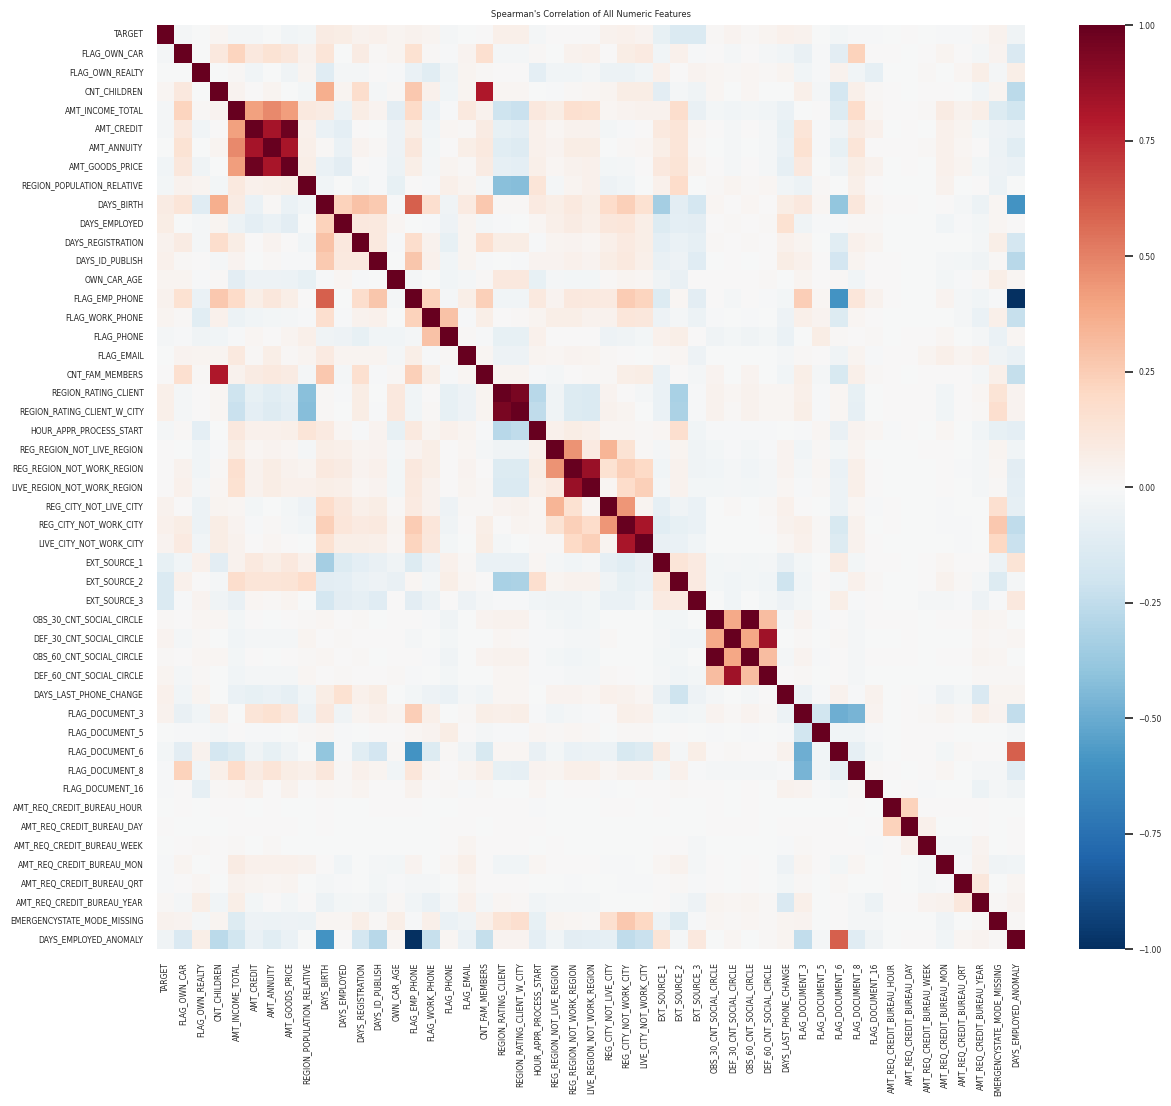

In [ ]:
plt.figure(figsize=(14, 12))
sns.set(font_scale=0.5)

sns.heatmap(corr_matrix, cmap='RdBu_r', vmin=-1, center=0, vmax=1)

plt.title("Spearman's Correlation of All Numeric Features")

plt.show()

sns.set(font_scale=1.0)

In [ ]:
stacked_corr = corr_matrix.stack().reset_index()
stacked_corr.columns = ['feature1', 'feature2', 'correlation']
stacked_corr = stacked_corr[stacked_corr['feature1'] != stacked_corr['feature2']]
stacked_corr.reset_index(drop=True, inplace=True)

stacked_corr["abs_corr"] = np.absolute(stacked_corr["correlation"])
display(stacked_corr[stacked_corr["abs_corr"]>=0.80].sort_values(by="abs_corr", ascending=False))

,feature1,feature2,correlation,abs_corr
2318,DAYS_EMPLOYED_ANOMALY,FLAG_EMP_PHONE,-1.000,1.000
719,FLAG_EMP_PHONE,DAYS_EMPLOYED_ANOMALY,-1.000,1.000
1615,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.997,0.997
1520,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,0.997,0.997
246,AMT_CREDIT,AMT_GOODS_PRICE,0.984,0.984
341,AMT_GOODS_PRICE,AMT_CREDIT,0.984,0.984
931,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,0.950,0.950
979,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,0.950,0.950
1127,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,0.863,0.863
1175,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,0.863,0.863


There seems to be high correlation between some variables, so we will be dropping some of them.

Furthermore, there seems to be strong correlation between ANNUITY, CREDIT and GOODS_PRICE. This makes sense, as annuity is calculated from credit, and goods price should be related to amount of credit to protect the lender in case of defaults and to justify the loan in the first place.

To avoid issues in multicollinearity, we will be transforming AMT_GOODS_PRICE and ANNUITY to ratio's of CREDIT.

Let's quickly check which features have high correlation with our target variable.

In [ ]:
stacked_corr[stacked_corr["feature1"]=="TARGET"].sort_values(by="abs_corr", ascending=False).head(10)

,feature1,feature2,correlation,abs_corr
28,TARGET,EXT_SOURCE_2,-0.147,0.147
29,TARGET,EXT_SOURCE_3,-0.142,0.142
27,TARGET,EXT_SOURCE_1,-0.085,0.085
8,TARGET,DAYS_BIRTH,0.079,0.079
9,TARGET,DAYS_EMPLOYED,0.075,0.075
19,TARGET,REGION_RATING_CLIENT_W_CITY,0.061,0.061
18,TARGET,REGION_RATING_CLIENT,0.059,0.059
34,TARGET,DAYS_LAST_PHONE_CHANGE,0.053,0.053
11,TARGET,DAYS_ID_PUBLISH,0.051,0.051
25,TARGET,REG_CITY_NOT_WORK_CITY,0.051,0.051


No strong relationship are visible.

Now, let's calculate VIF scores to see if there is any multicollinearity.

In [ ]:
high_corr_drop = ["OBS_30_CNT_SOCIAL_CIRCLE", "REGION_RATING_CLIENT_W_CITY", "DAYS_EMPLOYED_ANOMALY", "AMT_GOODS_PRICE"]

numeric_df.drop(columns=high_corr_drop, inplace=True)

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns

numeric_feat = vif_data["feature"].to_list()

vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i)
                          for i in range(len(numeric_df.columns))]

print(vif_data.sort_values(by="VIF", ascending=False).head(15))

                        feature    VIF
8                    DAYS_BIRTH 30.536
17              CNT_FAM_MEMBERS 28.639
18         REGION_RATING_CLIENT 18.479
26                 EXT_SOURCE_1 16.555
19      HOUR_APPR_PROCESS_START 13.823
6                   AMT_ANNUITY 11.794
13               FLAG_EMP_PHONE 11.616
28                 EXT_SOURCE_3 10.176
24       REG_CITY_NOT_WORK_CITY  9.822
27                 EXT_SOURCE_2  9.664
21   REG_REGION_NOT_WORK_REGION  9.496
5                    AMT_CREDIT  8.205
33              FLAG_DOCUMENT_3  8.086
22  LIVE_REGION_NOT_WORK_REGION  7.652
25      LIVE_CITY_NOT_WORK_CITY  7.345


Typically VIF scores above 5 or 10 are dropped due to multicollinearity. However, some of them (EXT_SOURCE columns) still have high feature importance. Therefore, we will hand pick features to be removed:
* CNT_FAM_MEMBERS - we already have CNT_CHILDREN, which is highly correlated.
* HOUR_APPR_PROCESS_START - Hour of the initial application should not be relevant in the first place.
Therefore, we will hand pick features to be removed:
* AMT_ANNUITY - highly correlated with AMT_CREDIT and AMT_GOODS_PRICE. An engineered version of this value will remain.



* DAYS_BIRTH - we will leave this feature for now, as it does sound important.

In [ ]:
high_vif_cols = ["CNT_FAM_MEMBERS", "HOUR_APPR_PROCESS_START", "AMT_ANNUITY"]

# Machine Learning

## Feature Engineering

As mentioned above, to avoid multicollinearity and extract additional information from the features, we will engineer some features by calculating ratio's between them.

In [ ]:
class AddIncomeToCredit(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["INCOME_TO_CREDIT"] = X["AMT_INCOME_TOTAL"] / X["AMT_CREDIT"]
        return X

class AddAnnuityToIncome(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["ANNUITY_TO_INCOME"] = X["AMT_ANNUITY"] / X["AMT_INCOME_TOTAL"]
        return X

class AddPaymentRate(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["PAYMENT_RATE"] = X["AMT_ANNUITY"] / X["AMT_CREDIT"]
        return X

class AddCreditToGoods(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["CREDIT_TO_GOODS"] = X["AMT_CREDIT"] / X["AMT_GOODS_PRICE"]
        return X

class AddEmploymentRate(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["EMPLOYMENT_RATE"] = X["DAYS_EMPLOYED"] / (X["DAYS_BIRTH"] + 18 * 365.25)
        return X

In [ ]:
engineered_cols = ["INCOME_TO_CREDIT", "ANNUITY_TO_INCOME", "PAYMENT_RATE", "CREDIT_TO_GOODS", "EMPLOYMENT_RATE"]

In [ ]:
feature_pipeline = Pipeline([
    ("add_income_to_credit", AddIncomeToCredit()),
    ("add_annuity_to_income", AddAnnuityToIncome()),
    ("add_payment_rate", AddPaymentRate()),
    ("add_credit_to_goods", AddCreditToGoods()),
    ("add_employment_rate", AddEmploymentRate()),
])

In [ ]:
trial_run = feature_pipeline.fit_transform(loans[["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "AMT_INCOME_TOTAL", "DAYS_EMPLOYED", "DAYS_BIRTH"]])

display(trial_run.head(3))
display(trial_run.describe())

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,DAYS_EMPLOYED,DAYS_BIRTH,INCOME_TO_CREDIT,ANNUITY_TO_INCOME,PAYMENT_RATE,CREDIT_TO_GOODS,EMPLOYMENT_RATE
234502,781920.000,28215.000,675000.000,180000.000,-4125.000,-13752,0.230,0.157,0.036,1.158,0.575
34261,1006920.000,42790.500,900000.000,202500.000,-3714.000,-10881,0.201,0.211,0.042,1.119,0.862
265488,814041.000,23931.000,679500.000,36000.000,NaN,-19282,0.044,0.665,0.029,1.198,NaN


,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,DAYS_EMPLOYED,DAYS_BIRTH,INCOME_TO_CREDIT,ANNUITY_TO_INCOME,PAYMENT_RATE,CREDIT_TO_GOODS,EMPLOYMENT_RATE
count,276759.000,276749.000,276507.000,276759.000,227004.000,276759.000,276759.000,276749.000,276749.000,276507.000,227004.000
mean,599215.288,27109.410,538587.260,168853.241,-2383.964,-16032.153,0.399,0.181,0.054,1.123,0.309
std,402518.161,14503.647,369452.720,247789.185,2340.121,4363.962,0.523,0.095,0.022,0.124,0.249
min,45000.000,1615.500,40500.000,25650.000,-17912.000,-25229.000,0.020,0.000,0.022,0.150,-0.000
25%,270000.000,16537.500,238500.000,112500.000,-3173.000,-19675.000,0.194,0.115,0.037,1.000,0.109
50%,513531.000,24903.000,450000.000,146250.000,-1646.000,-15745.000,0.306,0.163,0.050,1.119,0.239
75%,808650.000,34596.000,679500.000,202500.000,-766.000,-12406.000,0.495,0.229,0.064,1.198,0.449
max,4050000.000,258025.500,4050000.000,117000000.000,0.000,-7489.000,208.003,1.571,0.124,6.000,1.022


In [ ]:
loans.drop(columns=high_corr_drop + high_vif_cols, inplace=True)

## Pipeline

Let's make a pipeline for transforming the data. We'll begin by making a custom column dropper, and then construct a pipeline with different impute methods.

In [ ]:
drop_cols = building_cols + low_var_bi_cols + many_cat_cols + high_corr_drop + high_vif_cols + many_cat_cols + ["SK_ID_CURR"]

In [ ]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self

In [ ]:
edu_order =  [['Lower secondary',  'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree']]

In [ ]:
loans.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMERGENCYSTATE_MODE_MISSING
234502,371646,False,Cash loans,F,False,True,0,180000.000,781920.000,Higher education,0.036,-13752,-4125.000,-638.000,-4548,NaN,True,False,True,False,2,False,True,True,False,True,True,NaN,0.504,0.356,0.000,0.000,0.000,-105.000,True,False,False,False,False,0.000,0.000,0.000,0.000,0.000,1.000,True
34261,139700,False,Cash loans,F,True,True,1,202500.000,1006920.000,Higher education,0.011,-10881,-3714.000,-142.000,-274,4.000,True,False,True,False,2,False,False,False,True,False,True,NaN,0.324,NaN,0.000,0.000,0.000,-2257.000,True,False,False,False,False,0.000,0.000,0.000,0.000,0.000,0.000,False
265488,407492,False,Cash loans,F,False,False,0,36000.000,814041.000,Secondary / secondary special,0.001,-19282,NaN,-7224.000,-2821,NaN,False,False,True,False,2,False,False,False,False,False,False,NaN,0.059,0.120,0.000,0.000,0.000,-443.000,True,False,False,False,False,0.000,0.000,0.000,0.000,0.000,2.000,True
172932,300400,False,Cash loans,F,True,False,1,135000.000,2013840.000,Higher education,0.010,-15634,-2453.000,-1214.000,-4304,16.000,True,False,True,False,2,False,False,False,False,True,True,NaN,0.521,0.333,0.000,0.000,0.000,-445.000,True,False,False,False,True,0.000,0.000,0.000,0.000,0.000,4.000,True
88035,202199,False,Cash loans,F,False,False,0,157500.000,675000.000,Higher education,0.036,-15190,-3472.000,-2188.000,-1164,NaN,True,False,False,False,2,False,False,False,False,False,False,0.527,0.595,0.553,0.000,0.000,0.000,-528.000,False,False,False,True,False,0.000,0.000,0.000,1.000,0.000,1.000,False


In [ ]:
categorical_cols = ["NAME_CONTRACT_TYPE", "CODE_GENDER"]
bi_cols = []

for col in loans.drop(columns=["TARGET"]).columns:
    if hl.is_binary(loans[col]):
        bi_cols.append(col)

print("Binary columns:", len(bi_cols), bi_cols)

ordinal_cols = ["NAME_EDUCATION_TYPE"]

Binary columns: 18 ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_16', 'EMERGENCYSTATE_MODE_MISSING']


In [ ]:
num_cols = set(loans.columns) - set(["SK_ID_CURR", "TARGET"]) - set(categorical_cols) - set(bi_cols) - set(ordinal_cols) - set(many_cat_cols)
num_cols = list(num_cols)

In [ ]:
loans[num_cols].head()

,EXT_SOURCE_2,AMT_REQ_CREDIT_BUREAU_QRT,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1,OWN_CAR_AGE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_REQ_CREDIT_BUREAU_WEEK,DEF_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_MON,AMT_CREDIT,EXT_SOURCE_3,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY
234502,0.504,0.000,0.036,2,1.000,NaN,NaN,-4125.000,-13752,0.000,0.000,0.000,-105.000,0,0.000,-638.000,-4548,0.000,0.000,781920.000,0.356,180000.000,0.000
34261,0.324,0.000,0.011,2,0.000,NaN,4.000,-3714.000,-10881,0.000,0.000,0.000,-2257.000,1,0.000,-142.000,-274,0.000,0.000,1006920.000,NaN,202500.000,0.000
265488,0.059,0.000,0.001,2,2.000,NaN,NaN,NaN,-19282,0.000,0.000,0.000,-443.000,0,0.000,-7224.000,-2821,0.000,0.000,814041.000,0.120,36000.000,0.000
172932,0.521,0.000,0.010,2,4.000,NaN,16.000,-2453.000,-15634,0.000,0.000,0.000,-445.000,1,0.000,-1214.000,-4304,0.000,0.000,2013840.000,0.333,135000.000,0.000
88035,0.595,0.000,0.036,2,1.000,0.527,NaN,-3472.000,-15190,0.000,0.000,0.000,-528.000,0,0.000,-2188.000,-1164,0.000,1.000,675000.000,0.553,157500.000,0.000


In [ ]:
median_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")
zero_imputer = SimpleImputer(strategy="constant", fill_value=0)

scaler = StandardScaler()

cat_transf = Pipeline(
    steps=[
        ("impute", cat_imputer),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)),
    ]
)

num_transf = Pipeline(
    steps=[
        ("impute", median_imputer),
        ("scale", scaler)
    ]
)

bi_transf = median_imputer

ord_transf = Pipeline(
    steps=[
        ("encode", OrdinalEncoder(categories=edu_order, handle_unknown="use_encoded_value", unknown_value=np.nan)),
        ("impute", median_imputer)
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("to_bi", cat_transf, categorical_cols),
        ("bi", bi_transf, bi_cols),
        ("ordinal", ord_transf, ordinal_cols),
        ("num", num_transf, num_cols),
        ("engineered", median_imputer, engineered_cols)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

pipeline = Pipeline([
    ("feature_engineering", feature_pipeline),
    ("columnDropper", columnDropperTransformer(drop_cols)),
    ("preprocess", preprocessor),
])

X_train_proc = pipeline.fit_transform(X_train)
X_valid_proc = pipeline.transform(X_valid)

print(X_train_proc.shape)
display(X_train_proc.head(2))

(276759, 50)


,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_16,EMERGENCYSTATE_MODE_MISSING,NAME_EDUCATION_TYPE,EXT_SOURCE_2,AMT_REQ_CREDIT_BUREAU_QRT,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1,OWN_CAR_AGE,DAYS_EMPLOYED,DAYS_BIRTH,AMT_REQ_CREDIT_BUREAU_WEEK,DEF_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_MON,AMT_CREDIT,EXT_SOURCE_3,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,INCOME_TO_CREDIT,ANNUITY_TO_INCOME,PAYMENT_RATE,CREDIT_TO_GOODS,EMPLOYMENT_RATE
234502,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,3.000,-0.054,-0.397,1.076,-0.102,-0.440,0.012,-0.147,-0.876,0.522,-0.156,-0.320,-0.071,1.037,-0.579,-0.587,1.235,-1.030,-0.275,-0.270,0.454,-0.916,0.045,-0.058,0.230,0.157,0.036,1.158,0.575
34261,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,3.000,-1.000,-0.397,-0.716,-0.102,-1.007,0.012,-0.850,-0.684,1.180,-0.156,-0.320,-0.071,-1.564,0.810,-0.587,1.375,1.802,-0.275,-0.270,1.013,0.112,0.136,-0.058,0.201,0.211,0.042,1.119,0.862


## Decision Tree

              precision    recall  f1-score   support

       False       0.96      0.71      0.81     14134
        True       0.16      0.63      0.25      1242

    accuracy                           0.70     15376
   macro avg       0.56      0.67      0.53     15376
weighted avg       0.89      0.70      0.77     15376

Train AUC: 0.7338
Valid AUC: 0.7221


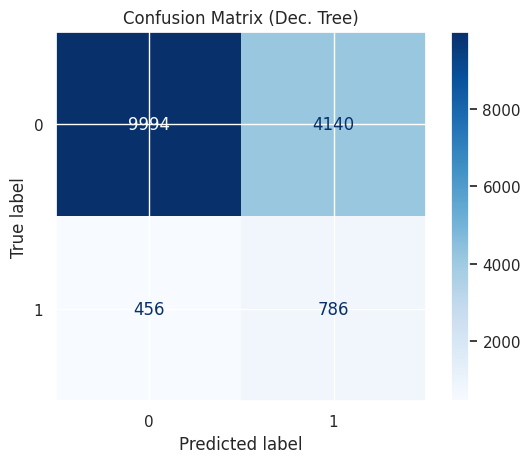

In [ ]:
dec_tree = DecisionTreeClassifier(class_weight="balanced", max_depth=7)

dec_tree.fit(X_train_proc, y_train)

yhat_valid = dec_tree.predict(X_valid_proc)

hl.show_results(dec_tree, X_train_proc, y_train, X_valid_proc, y_valid)

my.plot_confusion_matrix(y_valid, yhat_valid, "Dec. Tree")
plt.show()

The model performs adequately, but not impressive. So we will try Logistic Regression instead.

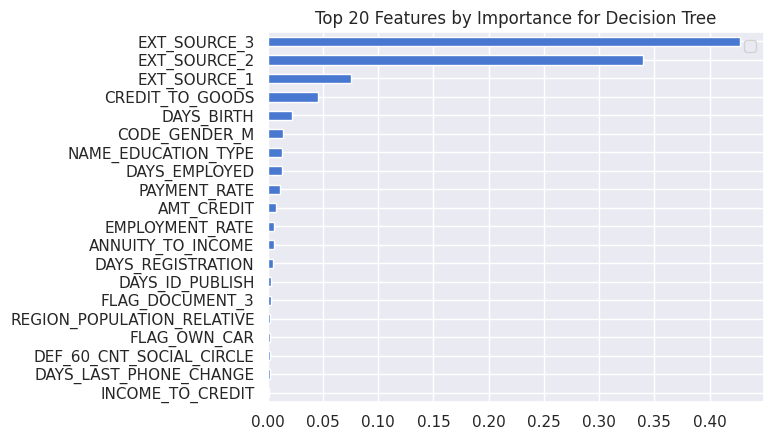

In [ ]:
tree_importances = pd.DataFrame({"Feature": X_train_proc.columns, "Importance": dec_tree.feature_importances_}).sort_values(by="Importance", ascending=False)

n = 20

importances_plot = tree_importances.head(n).sort_values(by="Importance", ascending=True)
importances_plot.plot(x='Feature', y='Importance', kind='barh', color='#4878d0' )

plt.title(f"Top {n} Features by Importance for Decision Tree")
plt.ylabel("")
plt.legend("")

plt.show()

Seems that the EXT_SOURCE columns carry with the most importance, with other columns having less of an impact.

Let's try good old Logistic Regression.

In [ ]:
models = hl.evaluate_model(dec_tree, "Decision Tree", X_valid_proc, y_valid)
models

,name,features_count,accuracy,precision,recall,f1_score,auc,inference_time,disk_space
0,Decision Tree,50,0.701,0.160,0.633,0.255,0.722,0.012,20889


## Logistic Regression

              precision    recall  f1-score   support

       False       0.96      0.69      0.80     14134
        True       0.16      0.66      0.25      1242

    accuracy                           0.69     15376
   macro avg       0.56      0.67      0.53     15376
weighted avg       0.89      0.69      0.76     15376

Train AUC: 0.7456
Valid AUC: 0.7404


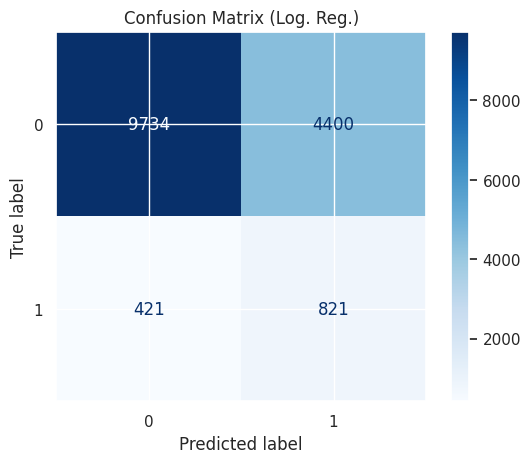

In [ ]:
log_reg = LogisticRegression(class_weight="balanced")

log_reg.fit(X_train_proc, y_train)

yhat_valid = log_reg.predict(X_valid_proc)

hl.show_results(log_reg, X_train_proc, y_train, X_valid_proc, y_valid)

my.plot_confusion_matrix(y_valid, yhat_valid, "Log. Reg.")
plt.show()

In [ ]:
log_models = hl.evaluate_model(log_reg, "Base", X_valid_proc, y_valid)
log_models

,name,features_count,accuracy,precision,recall,f1_score,auc,inference_time,disk_space
0,Base,50,0.686,0.157,0.661,0.254,0.740,0.014,2815


The model captures 2/3rds of Defaulted Loans while also labeling >5 times more loans as default than there actually are, indicating problems with handling imbalanced data.

Nevertheless, Logistic Regression model performs slightly better than the Decision Tree.

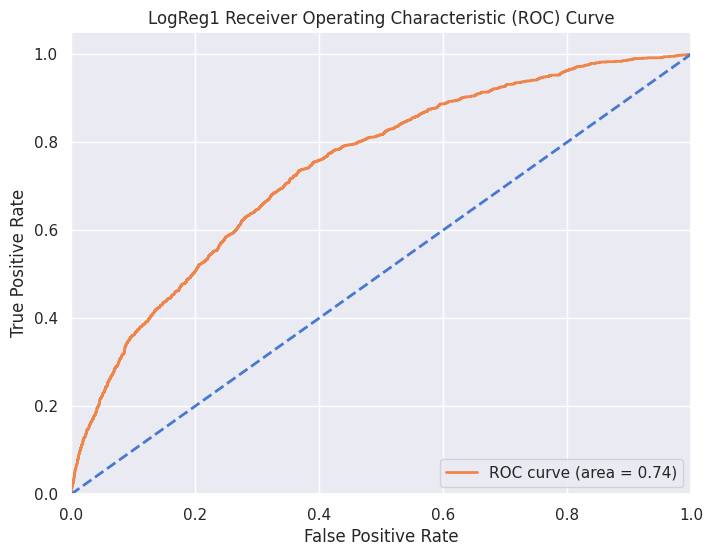

In [ ]:
my.plot_roc_curve(log_reg, X_valid_proc, y_valid, "LogReg1")

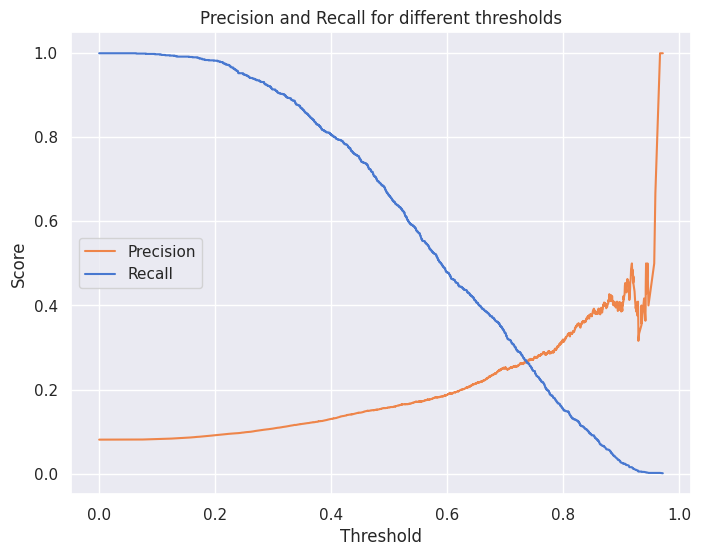

In [ ]:
my.plot_precision_recall_threshold(log_reg, X_valid_proc, y_valid)

Let's check feature importances.

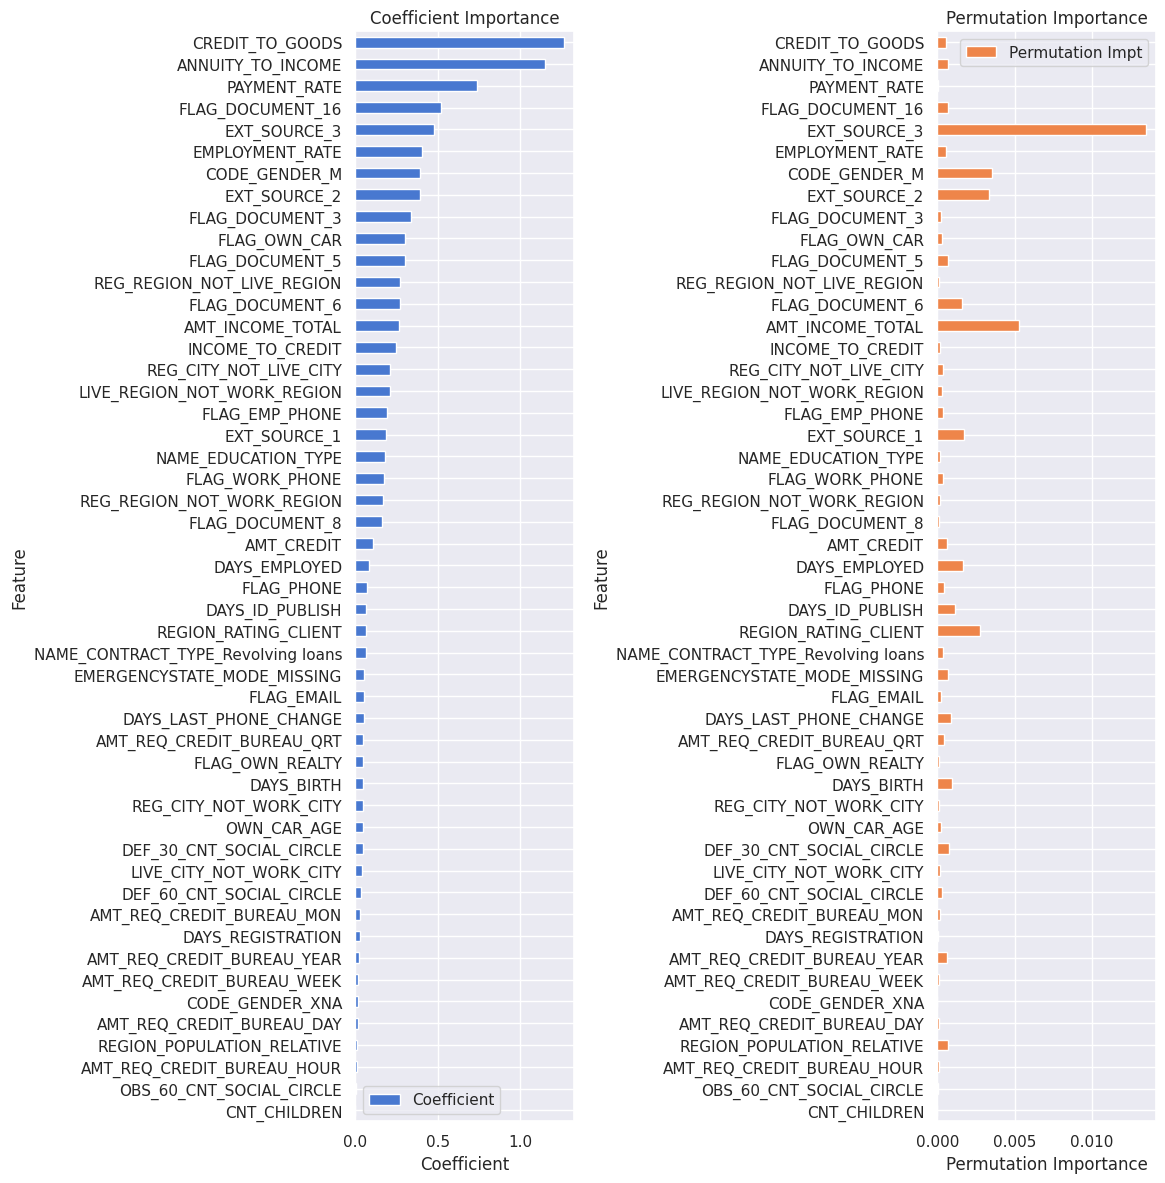

In [ ]:
coefficients = log_reg.coef_[0]
model_fi = permutation_importance(log_reg, X_valid_proc, y_valid)

feature_importances = pd.DataFrame({'Feature': X_train_proc.columns, 'Coefficient': np.abs(coefficients), 'Permutation Impt':np.abs(model_fi['importances_mean'])})
feature_importances = feature_importances.sort_values('Coefficient', ascending=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

feature_importances.plot(x='Feature', y='Coefficient', kind='barh', ax=ax1, color='#4878d0')
ax1.set_xlabel('Coefficient')
ax1.set_title('Coefficient Importance')

feature_importances.plot(x='Feature', y='Permutation Impt', kind='barh', ax=ax2, color='#ee854a')
ax2.set_xlabel('Permutation Importance')
ax2.set_title('Permutation Importance')

plt.tight_layout()
plt.show()

Model coefficients and permutation importance are indicating different features as important.

### Experimentation

We face three issues:
1. Presence of outliers in features of our linear model;
2. Imbalanced distribution of the target class;
3. Potential under-fitting.

To deal with them, we'll be programmatically trying the following combinations of techniques to see if any of the methods can boost performance:

Techniques to try:
* Dealing with outliers: as-is, IQR range method
* Sampling: as-is, oversample, undersample
* Polynomial: as-is, n=2

Since this is a minimalistic model, we'll only be trying polynomial regression for up to n=2.

In [ ]:
loans.drop(columns=["SK_ID_CURR"]).describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,276759.000,276759.000,276759.000,276759.000,276759.000,227004.000,276759.000,276759.000,94068.000,276759.000,120804.000,276160.000,221844.000,275828.000,275828.000,275828.000,276758.000,239379.000,239379.000,239379.000,239379.000,239379.000,239379.000
mean,0.417,168853.241,599215.288,0.021,-16032.153,-2383.964,-4987.840,-2994.015,12.066,2.052,0.502,0.514,0.511,0.143,1.406,0.100,-962.988,0.006,0.007,0.034,0.267,0.265,1.899
std,0.720,247789.185,402518.161,0.014,4363.962,2340.121,3523.358,1509.159,11.936,0.509,0.211,0.191,0.195,0.447,2.390,0.361,827.238,0.084,0.110,0.204,0.915,0.613,1.869
min,0.000,25650.000,45000.000,0.000,-25229.000,-17912.000,-24672.000,-7197.000,0.000,1.000,0.015,0.000,0.001,0.000,0.000,0.000,-4292.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,112500.000,270000.000,0.010,-19675.000,-3173.000,-7483.000,-4299.000,5.000,2.000,0.333,0.393,0.371,0.000,0.000,0.000,-1569.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,146250.000,513531.000,0.019,-15745.000,-1646.000,-4504.000,-3254.000,9.000,2.000,0.506,0.566,0.535,0.000,0.000,0.000,-757.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,1.000,202500.000,808650.000,0.029,-12406.000,-766.000,-2013.000,-1719.000,15.000,2.000,0.675,0.664,0.669,0.000,2.000,0.000,-273.000,0.000,0.000,0.000,0.000,0.000,3.000
max,19.000,117000000.000,4050000.000,0.073,-7489.000,0.000,0.000,0.000,91.000,3.000,0.963,0.855,0.896,34.000,344.000,24.000,0.000,4.000,9.000,8.000,27.000,19.000,25.000


In [ ]:
cols_w_outliers = ["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "DAYS_EMPLOYED", "DAYS_REGISTRATION"]

In [ ]:
def remove_outliers_df(X, y, cols):
    df = X.copy()
    df["target"] = y

    for col in cols:
        df = hl.remove_outliers(df, col)

    new_y = df.pop("target")
    return df, new_y

In [ ]:
X_new, y_new = remove_outliers_df(X_train, y_train, cols_w_outliers)

print(X_new.shape, y_new.shape, y_new.mean())

Bounds: -1.5 - 2.5
3839 rows removed.
Bounds: -22500.0 - 337500.0
12435 rows removed.
Bounds: -511245.0 - 1572075.0
5084 rows removed.
Bounds: -6723.0 - 2829.0
60763 rows removed.
Bounds: -14275.5 - 5640.5
518 rows removed.
(194120, 123) (194120,) 0.09189676488769834


In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
smote = SMOTE(random_state=42)

In [ ]:
techniques_grid = {
  "outliers": [None, "remove_iqr"],
  "sampling": [None, undersample, oversample, smote],
  "polynomial": [1, 2]
}

In [ ]:
for outlier in techniques_grid["outliers"]:
    if  outlier is None:
        X_new = X_train
        y_new = y_train

        name_1 = ""

    else:
        X_new, y_new = remove_outliers_df(X_train, y_train, cols_w_outliers)
        name_1 = "IQR, "

    X_new = pipeline.fit_transform(X_new)
    X_valid_proc = pipeline.transform(X_valid)

    for sampling in techniques_grid["sampling"]:
        X_sample = X_new
        y_sample = y_new

        if sampling is None:
            name_2 = "None, "
        else:
            X_sample, y_sample = sampling.fit_resample(X_sample, y_sample)

            if sampling == oversample:
                name_2 = "Over, "
            elif sampling == smote:
                name_2 = "SMOTE, "
            else:
                name_2 = "Under, "

        for n in [1, 2]:
            name_3 = f"^{n}"
            full_name = name_1 + name_2 + name_3

            poly_transformer = PolynomialFeatures(degree=n, include_bias=False)

            X_train_poly = poly_transformer.fit_transform(X_sample)
            X_valid_poly = poly_transformer.transform(X_valid_proc)

            model = LogisticRegression(class_weight="balanced")
            model.fit(X_train_poly, y_sample)

            log_models = hl.evaluate_model(model, full_name, X_valid_poly, y_valid, df=log_models)

Bounds: -1.5 - 2.5
3839 rows removed.
Bounds: -22500.0 - 337500.0
12435 rows removed.
Bounds: -511245.0 - 1572075.0
5084 rows removed.
Bounds: -6723.0 - 2829.0
60763 rows removed.
Bounds: -14275.5 - 5640.5
518 rows removed.


In [ ]:
log_models.sort_values(by="auc", ascending=False).reset_index().drop(columns="index").head(10)

,name,features_count,accuracy,precision,recall,f1_score,auc,inference_time,disk_space
0,"None, ^2",1325,0.685,0.157,0.665,0.254,0.746,0.081,72239
1,"Over, ^2",1325,0.686,0.157,0.663,0.254,0.746,0.077,72239
2,"Under, ^2",1325,0.675,0.155,0.679,0.252,0.742,0.078,72239
3,"Over, ^1",50,0.687,0.158,0.665,0.255,0.741,0.007,2815
4,Base,50,0.686,0.157,0.661,0.254,0.740,0.014,2815
5,"None, ^1",50,0.686,0.157,0.661,0.254,0.740,0.007,2815
6,"Under, ^1",50,0.687,0.158,0.660,0.254,0.740,0.007,2815
7,"IQR, None, ^2",1325,0.685,0.153,0.639,0.247,0.734,0.086,72239
8,"IQR, Over, ^2",1325,0.683,0.151,0.634,0.244,0.734,0.084,72239
9,"SMOTE, ^1",50,0.693,0.157,0.643,0.253,0.733,0.007,2815


* Adding polynomial features barely improves the performances. However, it does not seem like a good tradeoff for a minimalistic model.
* Removing outliers using interquartile range method does not seem to help.
* Sampling techniques do not seem to have any significant positive effect on model performance.

Therefore, we will be sticking with existing model.


### Feature Selection

To make it simple, we will use recursive feature elimination with cross-validation that is built in in Sklearn, and will keep features with top ranking only.

In [ ]:
X_train_proc = pipeline.fit_transform(X_train)
X_valid_proc = pipeline.transform(X_valid)

In [ ]:
model = LogisticRegression(class_weight="balanced")
rfecv_selector = RFECV(estimator=model, cv=5)

rfecv_selector.fit(X_train_proc, y_train)

RFECV(cv=5, estimator=LogisticRegression(class_weight='balanced'))

In [ ]:
feature_rankings = pd.DataFrame({"Feature": X_train_proc.columns, "Ranking": rfecv_selector.ranking_})

rank_one_features = feature_rankings[feature_rankings["Ranking"]==1]["Feature"].to_list()

Let's set aside low importance features so we can later drop them from the optimized pipeline.

In [ ]:
low_rfecv_rank_cols = set(feature_rankings["Feature"]) - set(rank_one_features)
low_rfecv_rank_cols = list(low_rfecv_rank_cols)

print("Features dropped:", len(low_rfecv_rank_cols))
print("Features left:", len(rank_one_features))

Features dropped: 15
Features left: 35


In [ ]:
X_train_proc = X_train_proc[rank_one_features]
X_valid_proc = X_valid_proc[rank_one_features]

              precision    recall  f1-score   support

       False       0.96      0.69      0.80     14134
        True       0.16      0.66      0.25      1242

    accuracy                           0.69     15376
   macro avg       0.56      0.67      0.53     15376
weighted avg       0.89      0.69      0.76     15376

Train AUC: 0.7447
Valid AUC: 0.7396


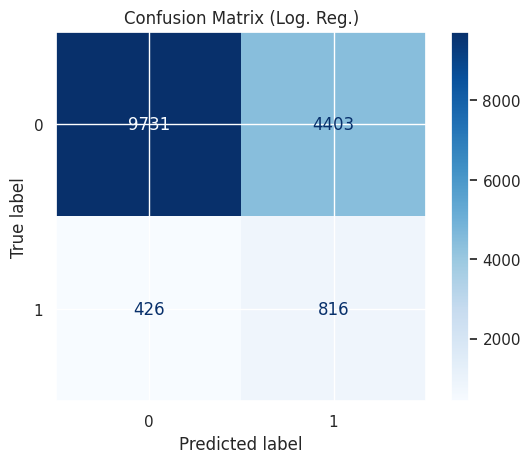

In [ ]:
log_reg_2 = LogisticRegression(class_weight="balanced")

log_reg_2.fit(X_train_proc, y_train)

yhat_valid = log_reg_2.predict(X_valid_proc)

hl.show_results(log_reg_2, X_train_proc, y_train, X_valid_proc, y_valid)

my.plot_confusion_matrix(y_valid, yhat_valid, "Log. Reg.")
plt.show()

In [ ]:
log_models2 = hl.evaluate_model(log_reg_2, "Minimal", X_valid_proc, y_valid, df=log_models)
log_models2.sort_values(by="auc",ascending=False).head(10)

,name,features_count,accuracy,precision,recall,f1_score,auc,inference_time,disk_space
0,"None, ^2",1325,0.685,0.157,0.665,0.254,0.746,0.081,72239
0,"Over, ^2",1325,0.686,0.157,0.663,0.254,0.746,0.077,72239
0,"Under, ^2",1325,0.675,0.155,0.679,0.252,0.742,0.078,72239
0,"Over, ^1",50,0.687,0.158,0.665,0.255,0.741,0.007,2815
0,Base,50,0.686,0.157,0.661,0.254,0.740,0.014,2815
0,"None, ^1",50,0.686,0.157,0.661,0.254,0.740,0.007,2815
0,"Under, ^1",50,0.687,0.158,0.660,0.254,0.740,0.007,2815
0,Minimal,35,0.686,0.156,0.657,0.253,0.740,0.012,2271
0,"IQR, None, ^2",1325,0.685,0.153,0.639,0.247,0.734,0.086,72239
0,"IQR, Over, ^2",1325,0.683,0.151,0.634,0.244,0.734,0.084,72239


We were able to sustain similar performance after dropping 15 features.

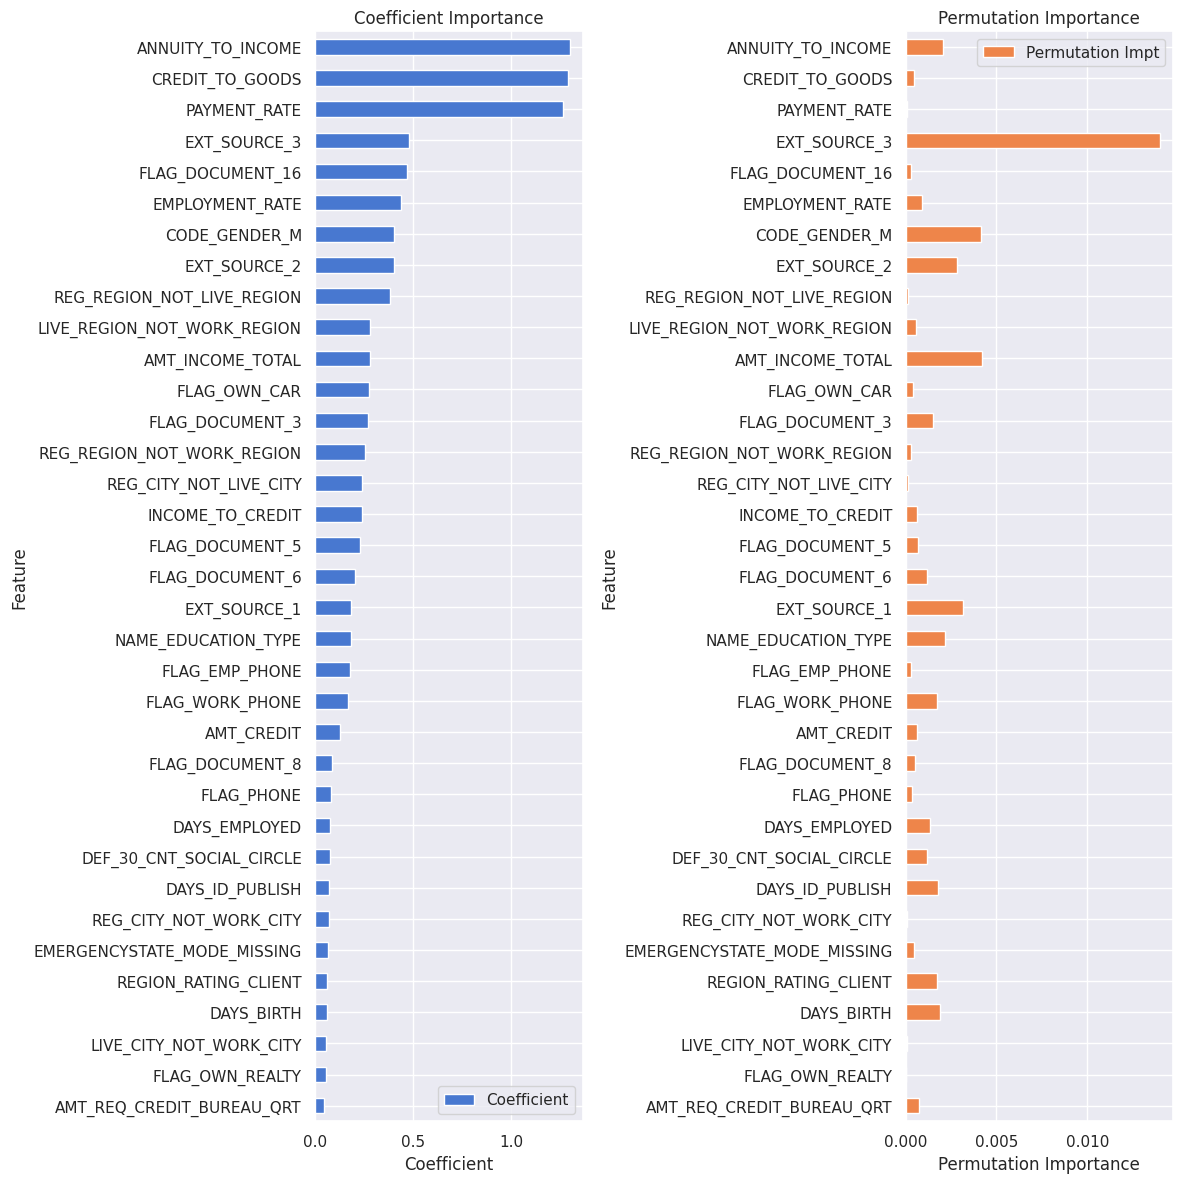

In [ ]:
coefficients = log_reg_2.coef_[0]
model_fi = permutation_importance(log_reg_2, X_valid_proc, y_valid)

feature_importances = pd.DataFrame({'Feature': X_train_proc.columns, 'Coefficient': np.abs(coefficients), 'Permutation Impt':np.abs(model_fi['importances_mean'])})
feature_importances = feature_importances.sort_values('Coefficient', ascending=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

feature_importances.plot(x='Feature', y='Coefficient', kind='barh', ax=ax1, color='#4878d0')
ax1.set_xlabel('Coefficient')
ax1.set_title('Coefficient Importance')

feature_importances.plot(x='Feature', y='Permutation Impt', kind='barh', ax=ax2, color='#ee854a')
ax2.set_xlabel('Permutation Importance')
ax2.set_title('Permutation Importance')

plt.tight_layout()
plt.show()

### Hyperparameter Tunning

For hyperparameter tunning we will use randomized search.

In [ ]:
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=["l2", "l1"],
                     solver=["liblinear", "sag", "saga"]
                     )

log_reg_param = LogisticRegression(class_weight="balanced")

random_search = RandomizedSearchCV(log_reg_param, distributions, n_iter=20, cv=5, random_state=42, scoring="roc_auc", n_jobs=-1)
random_search.fit(X_train_proc, y_train)

best_params = random_search.best_params_
print(best_params)

{'C': 0.7986951286334389, 'penalty': 'l2', 'solver': 'liblinear'}


{'C': 0.7986951286334389, 'penalty': 'l2', 'solver': 'liblinear'}

              precision    recall  f1-score   support

       False       0.96      0.69      0.80     14134
        True       0.16      0.66      0.25      1242

    accuracy                           0.69     15376
   macro avg       0.56      0.67      0.53     15376
weighted avg       0.89      0.69      0.76     15376

Train AUC: 0.7447
Valid AUC: 0.7399


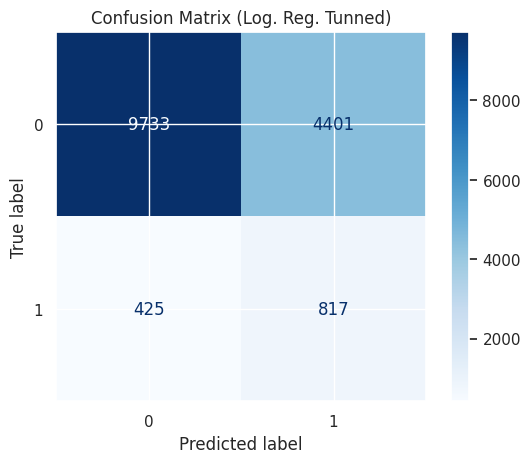

In [ ]:
log_reg_tunned = LogisticRegression(
    class_weight="balanced",
    solver="liblinear",
    C= 0.7986951286334389,
    penalty="l2"
    )

log_reg_tunned.fit(X_train_proc, y_train)

yhat_valid = log_reg_tunned.predict(X_valid_proc)

hl.show_results(log_reg_tunned, X_train_proc, y_train, X_valid_proc, y_valid)

my.plot_confusion_matrix(y_valid, yhat_valid, "Log. Reg. Tunned")
plt.show()

In [ ]:
log_models = hl.evaluate_model(log_reg_tunned, "Tunned", X_valid_proc, y_valid, df=log_models)
log_models.sort_values(by="auc",ascending=False).head(10)

,name,features_count,accuracy,precision,recall,f1_score,auc,inference_time,disk_space
0,"None, ^2",1325,0.685,0.157,0.665,0.254,0.746,0.081,72239
0,"Over, ^2",1325,0.686,0.157,0.663,0.254,0.746,0.077,72239
0,"Under, ^2",1325,0.675,0.155,0.679,0.252,0.742,0.078,72239
0,"Over, ^1",50,0.687,0.158,0.665,0.255,0.741,0.007,2815
0,Base,50,0.686,0.157,0.661,0.254,0.740,0.014,2815
0,"None, ^1",50,0.686,0.157,0.661,0.254,0.740,0.007,2815
0,"Under, ^1",50,0.687,0.158,0.660,0.254,0.740,0.007,2815
0,Tunned,35,0.686,0.157,0.658,0.253,0.740,0.011,2283
0,"IQR, None, ^2",1325,0.685,0.153,0.639,0.247,0.734,0.086,72239
0,"IQR, Over, ^2",1325,0.683,0.151,0.634,0.244,0.734,0.084,72239


Hyperparameter tunning barely made any improvements (only 0.0003 increase in validation set for AUC).

### Threshold Tunning according to Business Case

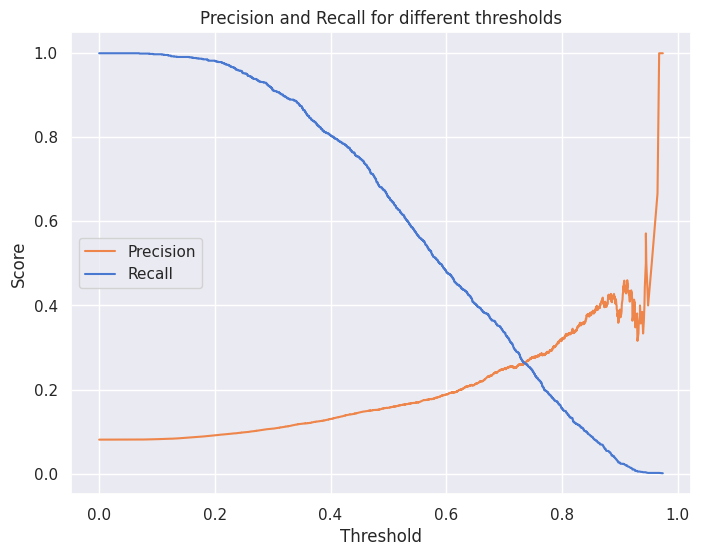

In [ ]:
my.plot_precision_recall_threshold(log_reg_tunned, X_valid_proc, y_valid)
plt.show()

Now that we tunned our model, let's adjust the threshold based on our business case tradeoffs.

Since there are different type of credit loans, and we don't have substantial information on the length of the loans, we cannot accurately estimate profits, as annuity does not tell us the interest rate paid, nor do we know HomeCredits operating expenses.

Therefore, we will make the following assumptions to estimate build our business case, by which we will tune our model's threshold:
1. When loan is defaulted, HomeCredit is able to recover 70% of the loan credit amount, thus resulting in a 30% LGD (Loss Given Default).
2. Total Rate of Return on a non-default loan is ~10% after accounting for related expenses.

Assumption 1 is based on Goldman Sachs Asset Management report:
"Historically, when borrowers have defaulted the recovery rate for all loans has averaged around 70% of par;"
Source: https://www.gsam.com/content/gsam/us/en/institutions/market-insights/gsam-insights/perspectives/2023/defaults-and-recovery-rates-in-private-credit.html

Assumption 2 is base on

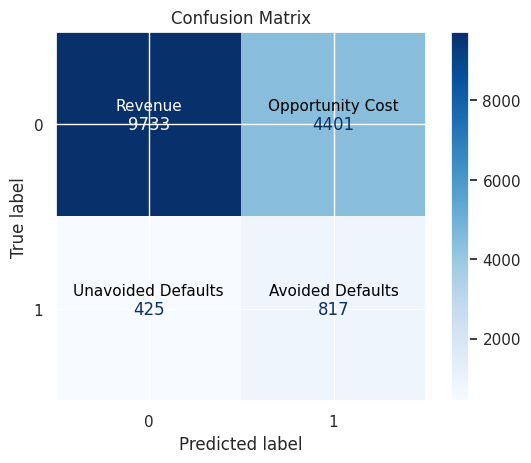

In [ ]:
cm = confusion_matrix(y_valid, yhat_valid)

cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

labels = ["Revenue", "Opportunity Cost", "Unavoided Defaults", "Avoided Defaults"]

def get_text_color(value, max_val):
    "Function to determine text color based on the background color"
    if value / max_val > 0.5:
        return "white"
    else:
        return "black"


max_val = cm.max()
for i in range(2):
    for j in range(2):
        color = get_text_color(cm[i, j], max_val)
        plt.text(j, i - 0.1, f"{labels[i*2 + j]}", ha="center", va="center",
                 color=color, fontsize=11 )

plt.show()

In [ ]:
y_valid_proba = log_reg_tunned.predict_proba(X_valid_proc)[:, 1]

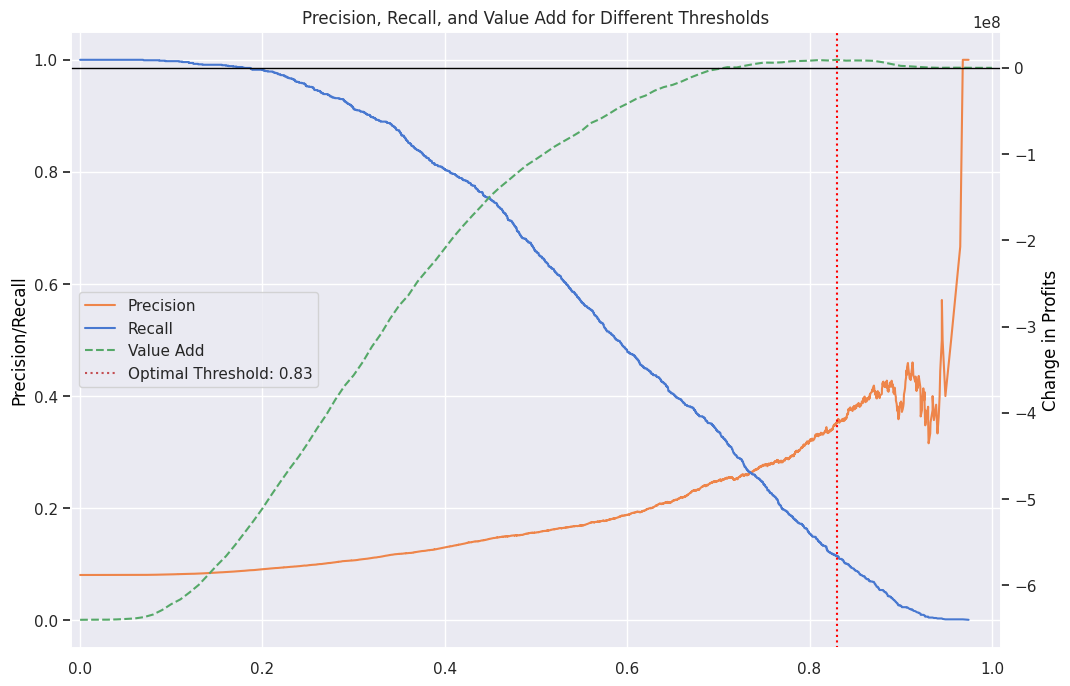

In [ ]:
optimal_threshold, max_value_add, thresholds, value_adds = hl.find_optimal_threshold(X_valid, y_valid, y_valid_proba)

precision, recall, pr_thresholds = precision_recall_curve(y_valid, y_valid_proba)


plt.figure(figsize=(12, 8))

plt.plot(pr_thresholds, precision[:-1], "#EE854A", label="Precision")
plt.plot(pr_thresholds, recall[:-1], "#4878d0", label="Recall")
plt.axvline(x=optimal_threshold, color="red", linestyle=":", label=f"Optimal Threshold: {optimal_threshold:.2f}")
plt.ylabel("Precision/Recall", color="black")

plt2 = plt.gca().twinx()
plt2.plot(thresholds, value_adds, "g--", label="Value Add")
plt2.axhline(y=0, color="black", linestyle="-", linewidth=1)
plt2.set_ylabel("Change in Profits", color="black")

plt.xlim(-0.01, 1.01)
plt.xlabel("Threshold")
plt.title("Precision, Recall, and Value Add for Different Thresholds")

plt.grid(True, axis="y")
plt2.grid(False)


legend_elements = [
    Line2D([0], [0], color="#EE854A", linestyle="-", label="Precision"),
    Line2D([0], [0], color="#4878d0", linestyle="-", label="Recall"),
    Line2D([0], [0], color="g", linestyle="--", label="Value Add"),
    Line2D([0], [0], color="r", linestyle=":", label=f"Optimal Threshold: {optimal_threshold:.2f}")
]

plt.legend(handles=legend_elements, loc="center left")

plt.show()

With our current assumptions, we see that precision is more important than recall, which is not ideal for this model, as it has better recall than precision on default parameters.

The model only brings additional value at probability threshold of ~0.7, and reaches optimal returns with probability of 0.83.

## Final Model

Let's optimize the pipeline so it can be saved together with the model and reused.

In [ ]:
log_reg = LogisticRegression(
    class_weight="balanced",
    solver="liblinear",
    C= 0.7986951286334389,
    penalty="l2"
    )

final_pipeline = Pipeline([
    ("feature_engineering", feature_pipeline),
    ("columnDropper1", columnDropperTransformer(drop_cols)),
    ("preprocess", preprocessor),
    ("columnDropper2", columnDropperTransformer(low_rfecv_rank_cols)),
    ("classifier", log_reg)
])

optimal_threshold = 0.83

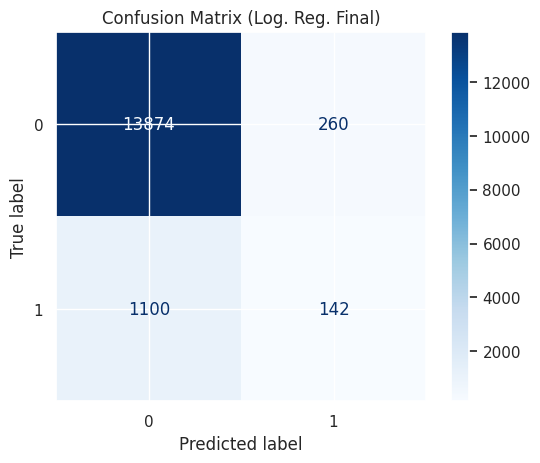

In [ ]:
final_pipeline.fit(X_train, y_train)

yhat_train_proba = final_pipeline.predict_proba(X_train)[:, 1]
yhat_train = (yhat_train_proba >= optimal_threshold)

yhat_valid_proba = final_pipeline.predict_proba(X_valid)
yhat_valid = (yhat_valid_proba >= optimal_threshold)[:, 1]

my.plot_confusion_matrix(y_valid, yhat_valid, "Log. Reg. Final")
plt.show()

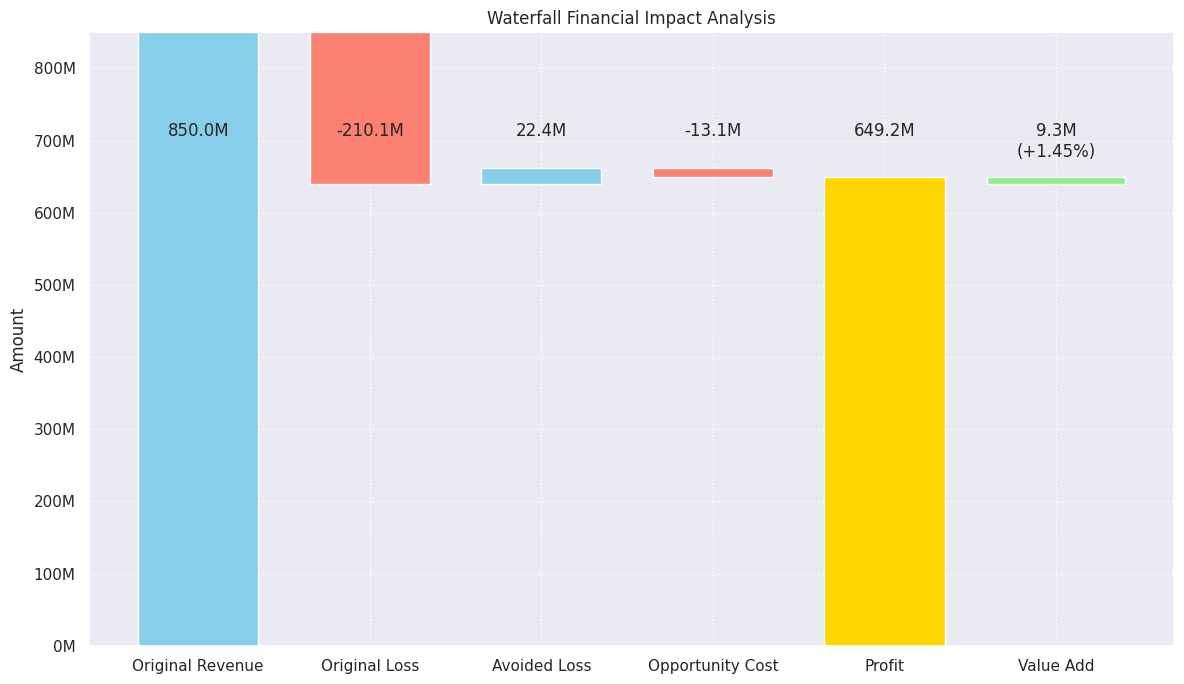

In [ ]:
original_case = hl.calculate_profit(X_valid, y_valid, [False] * len(y_valid))
new_case = hl.calculate_profit(X_valid, y_valid, yhat_valid)

org_revenue  = original_case["total_revenue"]
org_loss = -original_case["total_loss"]
avoided_loss = new_case["avoided_loss"]
opportunity_cost = -new_case["opportunity_cost"]

increments = [org_revenue, org_loss, avoided_loss, opportunity_cost]
categories = ["Original Revenue", "Original Loss", "Avoided Loss", "Opportunity Cost"]

my.waterfall_chart(increments, categories)

Based on our simulation and assumptions, our baseline model with 35 features from the original applications file would increase profits by ~1.45%.

In [ ]:
joblib.dump(feature_pipeline, dir_path + "model_files/" + "log_reg_w_pipe.joblib")

['/content/drive/MyDrive/Colab Notebooks/LoanDefaults/model_files/log_reg_w_pipe.joblib']

Let's save our model's metrics, so we can compare more complex models to it.

In [ ]:
baseline = log_models[log_models["name"]=="Tunned"]
baseline.to_csv(dir_path + "data/baseline_model.csv", index=False)